In [17]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
import pickle
rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])
import numpyro

from jax import random
import jax.numpy as jnp
from numpyro.infer import init_to_mean, init_to_value,init_to_median,init_to_feasible
import warnings
from typing import Callable, Dict,Tuple, List, Any

#path stuff
from pathlib import WindowsPath, PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
MODEL_PATH = PARENT_DIR.joinpath('.model')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference') 
MODEL_INFERENCE_PATH = PARENT_DIR.joinpath('.model_inference') 
IMAGE_PATH = PARENT_DIR.joinpath('images')
GIT_TABLE_PATH = PARENT_DIR.joinpath('.git_tables')
sys.path.append(str(PARENT_DIR))

from common_util import setup_axis_default, jmak_fit_model_setup,gl_fit_model_setup,kbar_jmak,kbar_gl,tbar,get_data_multiplier,\
                        _FILE_TO_LABEL as file_to_label
from model_inference.inflib import numpyro_hierarchical_posterior, _param_map as param_map,JMAKHierarchical,GLHierarchical, JMAKNumpyro

### Autocorrelation Plots

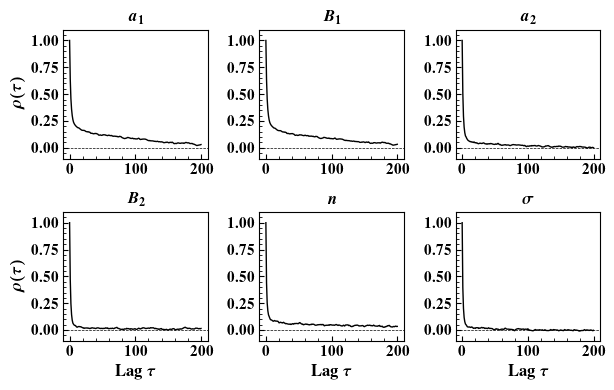

In [ ]:
def autocorr_fft(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=np.float64)
    N = x.size
    x -= x.mean()

    # pad to 2N
    nfft = 2 * N
    fx   = np.fft.rfft(x, n=nfft)
    p    = fx * np.conjugate(fx)
    acov = np.fft.irfft(p, n=nfft)[:N] / N

    # convert covariance → correlation
    return acov / acov[0]

fig,axes = plt.subplots(nrows = 2,ncols = 3,figsize = (6.25,4))

numpyro_model = JMAKNumpyro.load(str(MODEL_INFERENCE_PATH.joinpath('JMAK_Lopez et al. (2015) - MR_trunc_normal.pkl')))

params = {'a1': r'$a_1$','B1': r'$B_1$', 'a2': r'$a_2$','B2': r'$B_2$','n' :r'$n$','sigma': r'$\sigma$'}

for param,ax in zip(params,axes.flat):

    setup_axis_default(ax)
    ax.set_title(params[param],fontsize = 12,fontweight = 'bold')  
    ax.set_ylim([-0.1,1.1])
    ax.set_yticks(np.arange(0,1.25,0.25))
    data = numpyro_model.posterior_samples[param]
    rho = autocorr_fft(data)[:201]
    ax.plot(np.arange(0,201),rho,linewidth = 1.0,color = 'black')   
    ax.axhline(0,linestyle = '--',color = 'black',linewidth = 0.5)


for i in range(2):
    axes[i,0].set_ylabel(r'$\rho(\tau)$',fontsize = 12,fontweight = 'bold')
 
for i in range(3):
    axes[1,i].set_xlabel(r'\textbf{Lag} $\tau$',fontsize = 12,fontweight = 'bold')

fig.tight_layout()
fig.savefig(IMAGE_PATH.joinpath('autocorr_jmak.svg'),bbox_inches = 'tight')

### Trace Plots

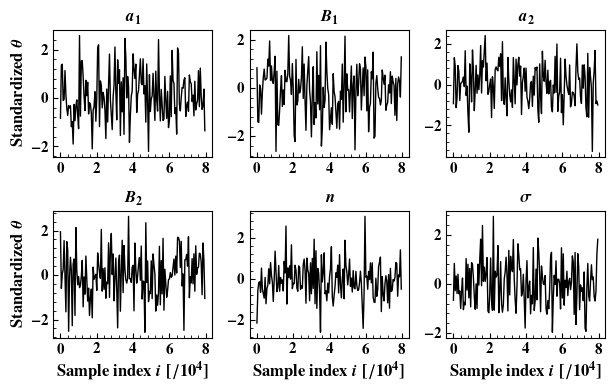

In [25]:
fig,axes = plt.subplots(nrows = 2,ncols = 3,figsize = (6.25,4))

numpyro_model = JMAKNumpyro.load(str(MODEL_INFERENCE_PATH.joinpath('JMAK_Lopez et al. (2015) - MR_trunc_normal.pkl')))

params = {'a1': r'$a_1$','B1': r'$B_1$', 'a2': r'$a_2$','B2': r'$B_2$','n' :r'$n$','sigma': r'$\sigma$'}

thin = 500
for param,ax in zip(params,axes.flat):

    setup_axis_default(ax)
    ax.set_title(params[param],fontsize = 12,fontweight = 'bold')  
    data = numpyro_model.posterior_samples[param]
    data = (data - data.mean())/data.std()
    ax.plot(np.arange(0,data.shape[0],thin,dtype = float)/1e4,data[::thin],linewidth = 1.0,color = 'black')   
    ax.set_xticks(np.arange(0,9,2))

for i in range(2):
    axes[i,0].set_ylabel(r'\textbf{Standardized} $\theta$',fontsize = 12,fontweight = 'bold')
 
for i in range(3):
    axes[1,i].set_xlabel(r'\textbf{Sample index} $i$ \textbf{[$/10^4$]}',fontsize = 12,fontweight = 'bold')

fig.tight_layout()
fig.savefig(IMAGE_PATH.joinpath('trace_plots_jmak.svg'),bbox_inches = 'tight')